# Sonar data - Rocks or Mines?

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/sonar.gif)

Sonar (sound navigationa ranging) is a technique based on the principle of reflection of ultrasonic sound waves. These waves propogate through water and reflect on hitting the ocean bed or any object obstructing its path.

Sonar has been widely used in submarine navigation, communication with or detection of objects on or underthe water surface (like other vessels), hazard identification etc.

Neural networks can be used to automate the process of identifying the objects from which the waves bounced off.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
import random
import matplotlib.pyplot as plt

# The dataset

>This dataset was used in 
>Gorman, R. P., and Sejnowski, T. J. (1988). “Analysis of Hidden Units in a Layered Network Trained to Classify Sonar Targets” in Neural Networks, Vol. 1, pp. 75-89.

The CSV files contain data regarding sonar signals bounced off a metal cylinder (mines - M) and a roughly cylindrical rock (rock - R) at various angles and under various conditions.

In [2]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/sonar.all-data.csv', header = None)
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


In [3]:
# The spread of labels in the dataframe

df[60].value_counts()

M    111
R     97
Name: 60, dtype: int64

This is a fairly balanced dataset.

# Preprocessing

## Categorical features

The class attribute has R and M to denote the classes. We have to convert them into numeric values.

In [4]:
df[60] = (df[60] == 'M').astype('int')
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,1
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,1
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,1
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,1


In [5]:
# Storing the class names corresponding to the index in arrays for reference later.

class_names = ['Rocks', 'Mines']

## Balancing dataset

Even though there is only a difference of only 14 samples, in comparison to the total number of data samples available, this needs to be balanced.

In [6]:
# separating into 2 dataframes, one for each class 

df0 = df[df[60] == 0]
df1 = df[df[60] == 1]

In [7]:
print("Number of samples in:")
print("Class label 0 - ", len(df0))
print("Class label 1 - ", len(df1))

# Upsampling 

df0 = df0.sample(len(df1), replace = True)    # replace = True enables resampling

print('\nAfter resampling - ')

print("Number of samples in:")
print("Class label 0 - ", len(df0))
print("Class label 1 - ", len(df1))

Number of samples in:
Class label 0 -  97
Class label 1 -  111

After resampling - 
Number of samples in:
Class label 0 -  111
Class label 1 -  111


In [8]:
# concatente to form a single dataframe

df = df1.append(df0)

print('Total number of samples - ', len(df))

Total number of samples -  222


In [9]:
# defining the input and output columns to separate the dataset in the later cells.

input_columns = list(df.columns[:-1]) 
output_columns = [df.columns[-1]]

print("Number of input columns: ", len(input_columns))
#print("Input columns: ", ', '.join(input_columns))

print("Number of output columns: ", len(output_columns))
#print("Output columns: ", ', '.join(output_columns))

Number of input columns:  60
Number of output columns:  1


## Train - val split

In [10]:
# Splitting into train and val set -- 90-10 split

train_df, val_df = train_test_split(df, test_size = 0.1, random_state = 2)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))

Number of samples in...
Training set:  199
Validation set:  23


In [11]:
# Looking into the spread of values in the train and val sets

print("Training - ")
print(train_df[60].value_counts())

print("\nValidation - ")
print(val_df[60].value_counts())

Training - 
1    100
0     99
Name: 60, dtype: int64

Validation - 
0    12
1    11
Name: 60, dtype: int64


In [12]:
# Splitting into X (input) and y (output)

Xtrain, ytrain = np.array(train_df[input_columns]), np.array(train_df[output_columns])

Xval, yval = np.array(val_df[input_columns]), np.array(val_df[output_columns])

## Standardization

In [13]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.00000
mean,0.028412,0.035416,0.041039,0.052488,0.075295,0.107186,0.122463,0.132999,0.176829,0.204480,...,0.013050,0.010248,0.010601,0.009070,0.008181,0.008009,0.007409,0.007484,0.006115,0.50000
std,0.022135,0.031228,0.036280,0.047117,0.057561,0.060715,0.061606,0.090838,0.119279,0.136543,...,0.009367,0.007131,0.007366,0.007014,0.005718,0.005732,0.006147,0.005580,0.004703,0.50113
min,0.001500,0.000600,0.001500,0.006100,0.006700,0.010200,0.013000,0.005500,0.011700,0.011300,...,0.000800,0.000500,0.001000,0.000600,0.000400,0.000700,0.000300,0.000100,0.000600,0.00000
25%,0.013500,0.014600,0.017100,0.023200,0.038400,0.068175,0.084150,0.073875,0.094925,0.103600,...,0.007225,0.004800,0.004950,0.003900,0.004250,0.003700,0.003500,0.003900,0.003125,0.00000
50%,0.021600,0.027900,0.032500,0.039650,0.061200,0.092900,0.105600,0.111250,0.146250,0.177300,...,0.010800,0.008150,0.008800,0.007250,0.006800,0.006050,0.005550,0.006250,0.005300,0.50000
75%,0.035050,0.044550,0.053750,0.063150,0.098200,0.142050,0.153900,0.168400,0.230200,0.269300,...,0.016200,0.013600,0.014350,0.012100,0.010800,0.010875,0.009825,0.009000,0.007650,1.00000
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900,1.00000


The range of values for the attributes are almost of the same range, but the little difference has caused a shift of the means.

In [14]:
# Using standard scaler to standardize them to values with mean = 0 and variance = 1.

standard_scaler = StandardScaler()

# Fit on training set alone
Xtrain = standard_scaler.fit_transform(Xtrain)

# Use it to transform val and test input
Xval = standard_scaler.transform(Xval)
#Xtest = standard_scaler.transform(Xtest)

In [15]:
pd.DataFrame(Xtrain).describe()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,...,1.990000e+02,1.990000e+02,1.990000e+02,199.000000,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02
mean,1.829915e-16,-6.136911e-18,-1.338962e-16,-3.570567e-17,8.926416e-17,3.213510e-16,3.280458e-16,-3.570567e-16,6.248491e-17,1.428227e-16,...,-3.570567e-16,-1.696019e-16,5.355850e-17,0.000000,-2.276236e-16,-4.909529e-17,1.807599e-16,-1.071170e-16,-2.677925e-17,2.298552e-16
std,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,...,1.002522e+00,1.002522e+00,1.002522e+00,1.002522,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00,1.002522e+00
min,-1.240020e+00,-1.106128e+00,-1.131181e+00,-9.818601e-01,-1.170349e+00,-1.585533e+00,-1.815580e+00,-1.430497e+00,-1.400825e+00,-1.368609e+00,...,-1.285838e+00,-1.295750e+00,-1.358924e+00,-1.247771,-1.232853e+00,-1.301903e+00,-1.308985e+00,-1.174772e+00,-1.359696e+00,-1.186238e+00
25%,-6.854429e-01,-6.886172e-01,-6.533979e-01,-6.222756e-01,-6.654813e-01,-6.624383e-01,-6.410592e-01,-6.819884e-01,-7.021816e-01,-7.547718e-01,...,-6.827978e-01,-6.418061e-01,-7.874527e-01,-0.796976,-7.519414e-01,-6.767385e-01,-7.758174e-01,-6.461203e-01,-5.967326e-01,-6.241377e-01
50%,-2.775306e-01,-2.263156e-01,-2.501817e-01,-2.668361e-01,-2.365967e-01,-2.663528e-01,-2.435037e-01,-2.382414e-01,-2.217331e-01,-1.974295e-01,...,-1.551373e-01,-2.410019e-01,-2.724230e-01,-0.236896,-2.564568e-01,-2.252304e-01,-3.492831e-01,-2.991928e-01,-1.789194e-01,-2.077669e-01
75%,3.091299e-01,2.711784e-01,3.836411e-01,3.103645e-01,3.890007e-01,5.531631e-01,5.087175e-01,3.913769e-01,4.437614e-01,4.609515e-01,...,3.808987e-01,3.338356e-01,4.048764e-01,0.521261,4.430508e-01,3.825689e-01,5.126718e-01,4.194427e-01,2.661426e-01,2.918780e-01
max,4.974914e+00,6.316291e+00,7.275600e+00,7.728998e+00,5.487493e+00,4.524791e+00,4.121359e+00,3.632125e+00,4.231122e+00,3.638418e+00,...,7.123227e+00,6.098032e+00,4.073581e+00,3.355810,5.193873e+00,5.435986e+00,4.875763e+00,6.044624e+00,5.234487e+00,7.828189e+00


The means are (almost) 0.

# The model

In [16]:
model = Sequential([
    Dense(64, activation = 'relu', input_shape = Xtrain[0].shape),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cb = [EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [17]:
model.compile(optimizer=Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

history1 = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=16, callbacks = cb)

Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.5833 - accuracy: 0.6231 - val_loss: 0.4189 - val_accuracy: 0.8696
Epoch 2/16
7/7 [==============================] - 0s 3ms/step - loss: 0.2529 - accuracy: 0.9246 - val_loss: 0.2899 - val_accuracy: 0.8696
Epoch 3/16
7/7 [==============================] - 0s 3ms/step - loss: 0.1194 - accuracy: 0.9598 - val_loss: 0.1452 - val_accuracy: 0.9130
Epoch 4/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0540 - accuracy: 0.9849 - val_loss: 0.1530 - val_accuracy: 0.9565
Epoch 5/16
7/7 [==============================] - 0s 4ms/step - loss: 0.0305 - accuracy: 0.9899 - val_loss: 0.1429 - val_accuracy: 0.9565
Epoch 6/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 0.1531 - val_accuracy: 0.9565
Epoch 7/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9130
Epoch 8/16
7/7 [=================

In [18]:
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

history2 = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=16, callbacks = cb)

Epoch 1/16
7/7 [==============================] - 0s 19ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.1388 - val_accuracy: 0.9565
Epoch 2/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1381 - val_accuracy: 0.9130
Epoch 3/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1475 - val_accuracy: 0.9130
Epoch 4/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1561 - val_accuracy: 0.9130
Epoch 5/16
7/7 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1674 - val_accuracy: 0.9130
Epoch 6/16
7/7 [==============================] - 0s 3ms/step - loss: 9.8171e-04 - accuracy: 1.0000 - val_loss: 0.1739 - val_accuracy: 0.9130
Epoch 7/16
7/7 [==============================] - 0s 4ms/step - loss: 7.6978e-04 - accuracy: 1.0000 - val_loss: 0.1789 - val_accuracy: 0.9130


In [19]:
model.evaluate(Xval, yval)

1/1 [==============================] - 0s 1ms/step - loss: 0.1381 - accuracy: 0.9130


[0.138086199760437, 0.9130434989929199]

# Plotting the metrics

In [20]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

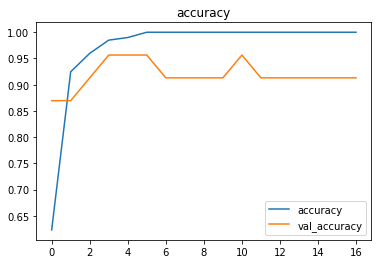

In [21]:
plot(history1.history, history2.history, "accuracy", 'val_accuracy')

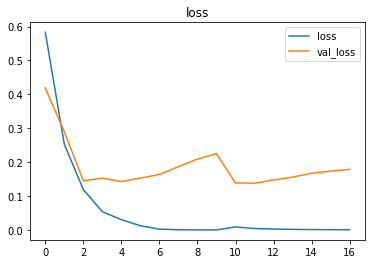

In [22]:
plot(history1.history, history2.history, "loss", 'val_loss')

# Prediction

In [23]:
# pick random test data sample from one batch
x = random.randint(0, len(Xval) - 1)

output_true = np.array(yval)[x][0]
print("True: ", class_names[output_true])

output = model.predict(Xval[x].reshape(1, -1))[0][0]
pred = int(output>0.5)    # finding max
print("Predicted: ", class_names[pred], "(",output, "-->", pred, ")")    # Picking the label from class_names base don the model 

True:  Mines
Predicted:  Mines ( 0.9999995 --> 1 )


# deepC

In [24]:
model.save('sonar.h5')

!deepCC sonar.h5

reading [keras model] from 'sonar.h5'
Saved 'sonar.onnx'
reading onnx model from file  sonar.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) dense_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_3's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_3) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  sonar_deepC/sonar.cpp
INFO (ONNX): model files are ready in dir sonar_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 sonar_deepC/sonar.cpp -o sonar_deepC/sonar.exe
Model executable  sonar_deepC/sonar.exe


In [25]:
# pick random test data sample from one batch
x = random.randint(0, len(Xval) - 1)

output_true = np.array(yval)[x][0]
print("True: ", class_names[output_true])

np.savetxt('sample.data', Xval[x])

# run exe with input
!sonar_deepC/sonar.exe sample.data

# show predicted output
nn_out = np.loadtxt('dense_3.out')

pred = int(nn_out>0.5)    # finding max
print("Predicted: ", class_names[pred], "(",nn_out, "-->", pred, ")")    # Picking the label from class_names base don the model output

True:  Rocks
reading file sample.data.
writing file dense_3.out.
Predicted:  Rocks ( 2.99045e-06 --> 0 )
